In [74]:
import random
import warnings
warnings.filterwarnings('ignore')

from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4
from datetime import timedelta, datetime

import matplotlib.pyplot as plt

import netCDF4

from ipyleaflet import Map, Velocity, basemaps, CircleMarker
import xarray as xr

In [75]:
plastic_drop_coords = {
    'Barcelona': [41, 2.195182],
    'Tripoli': [33, 13.161539],
    'Sicilia': [36.8, 14.3],
    'Athens': [36.895174, 21.499637]
}

europe_domain = {'N': 47, 'S': 30, 'E': 40, 'W': -5}

In [76]:
xr.open_dataset('../data/sv04-med-ingv-cur-an-fc-d_1552135429007.nc')

<xarray.Dataset>
Dimensions:  (depth: 1, lat: 380, lon: 1287, time: 1)
Coordinates:
  * depth    (depth) float32 1.0182366
  * lon      (lon) float32 -17.291666 -17.25 -17.208334 ... 36.25 36.291668
  * time     (time) datetime64[ns] 2018-01-01
  * lat      (lat) float32 30.1875 30.229166 30.270834 ... 45.9375 45.979168
Data variables:
    vo       (time, depth, lat, lon) float32 ...
    uo       (time, depth, lat, lon) float32 ...
Attributes:
    bulletin_type:                   forecast
    institution:                     Istituto Nazionale di Geofisica e Vulcan...
    source:                          MFS EAS3
    contact:                         servicedesk.cmems@mercator-ocean.eu
    references:                      Please check in CMEMS catalogue the INFO...
    comment:                         Please check in CMEMS catalogue the INFO...
    Conventions:                     CF-1.0
    bulletin_date:                   2019-03-08
    FROM_ORIGINAL_FILE__field_type:  daily_mean_cent

In [77]:
netCDF4.Dataset('../data/sv04-med-ingv-cur-an-fc-d_1552135429007.nc')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    bulletin_type: forecast
    institution: Istituto Nazionale di Geofisica e Vulcanologia - Bologna, Italy
    source: MFS EAS3
    contact: servicedesk.cmems@mercator-ocean.eu
    references: Please check in CMEMS catalogue the INFO section for product MEDSEA_ANALYSIS_FORECAST_PHY_006_013 - http://marine.copernicus.eu
    comment: Please check in CMEMS catalogue the INFO section for product MEDSEA_ANALYSIS_FORECAST_PHY_006_013 - http://marine.copernicus.eu
    Conventions: CF-1.0
    bulletin_date: 2019-03-08
    FROM_ORIGINAL_FILE__field_type: daily_mean_centered_at_time_field
    title: Horizontal Velocity (3D) - Daily Mean 
    _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
    history: Data extracted from dataset http://localhost:8080/thredds/dodsC/sv04-med-ingv-cur-an-fc-d
    dimensions(sizes): time(1), depth(1), lat(380), lon(1287)
    variables(dimensions): float32 depth(d

In [78]:
m = Map(
    center=[39, 12],
    zoom=5,
    basemap=basemaps.CartoDB.DarkMatter,
    dragging=False,
    touch_zoom=False,
    double_click_zoom=False,
    box_zoom=False,
    tap=False,
    keyboard=False,
    zoom_control=False,
    attribution_control=False
)

ds = xr.open_dataset('../data/sv04-med-ingv-cur-an-fc-d_1552135429007.nc')
del ds['time'], ds['depth']

ds['uo'] = ds['uo'][0, 0, :, :]
ds['vo'] = ds['vo'][0, 0, :, :]

currents = Velocity(
    data=ds,
    zonal_speed='uo',
    meridional_speed='vo',
    latitude_dimension='lat',
    longitude_dimension='lon',
    min_velocity=0,
    max_velocity=float(max(ds['uo'].max().data, ds['vo'].max().data)),
    velocity_scale=1
)
m.add_layer(currents)

for location, local_coords in plastic_drop_coords.items():
    circle_marker = CircleMarker()
    circle_marker.location = (local_coords[0], local_coords[1])
    circle_marker.radius = 5
    circle_marker.color = "red"
    circle_marker.fill_color = "red"
    circle_marker.weight = 2
    
    m.add_layer(circle_marker)

m

Map(attribution_control=False, basemap={'url': 'http://c.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png', 'max…

In [50]:
filenames = {
    'U': "../data/sv04-med-ingv-cur-an-fc-d_1552135429007.nc",
    'V': "../data/sv04-med-ingv-cur-an-fc-d_1552135429007.nc"
}

variables = {
    'U': 'uo',
    'V': 'vo'
}

dimensions = {
    'lat': 'lat',
    'lon': 'lon'
}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=True)

In [66]:
def generate_points(lon, lat, start_time, spread=0.1, N=10):
    lons, lats, times = [], [], []
    
    curr_time = start_time# + timedelta(hours=random.randint(0, 5))
    for _ in range(N):
        lons.append(random.gauss(lon, spread))
        lats.append(random.gauss(lat, spread))
        times.append(curr_time)
        
        #curr_time += timedelta(minutes=random.randint(0, 60))
    
    return lons, lats, times

init_lons, init_lats, init_times = [], [], []

start_time = datetime(2018, 1, 1)
for location, local_coords in plastic_drop_coords.items():
    lons, lats, times = generate_points(lat=local_coords[0], lon=local_coords[1], start_time=start_time)
    
    init_lons.extend(lons)
    init_lats.extend(lats)
    init_times.extend(times)

pset = ParticleSet.from_list(
    fieldset=fieldset,
    pclass=JITParticle,
    lon=init_lons,
    lat=init_lats
)

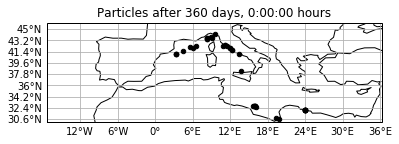

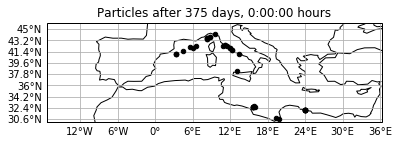

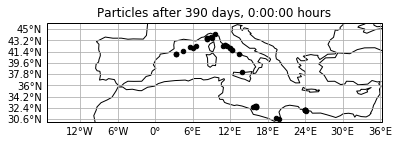

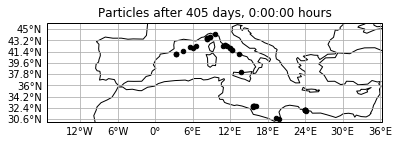

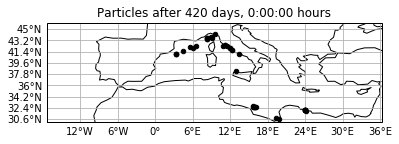

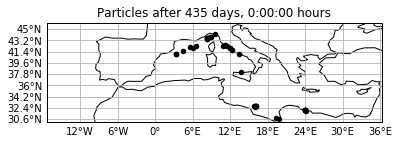

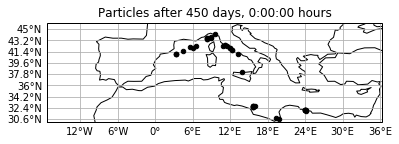

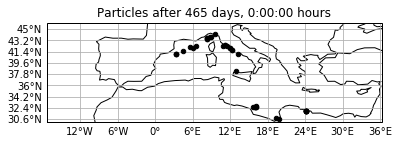

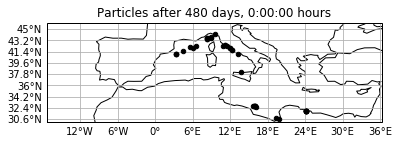

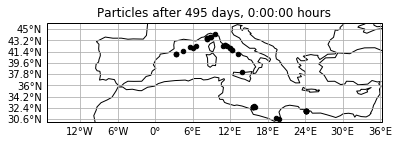

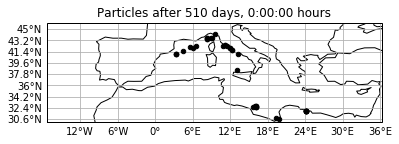

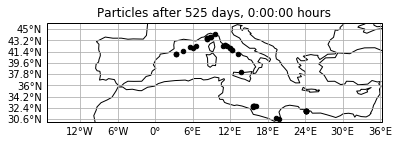

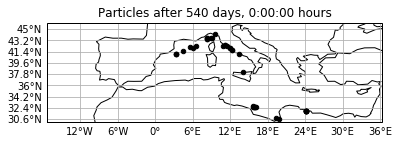

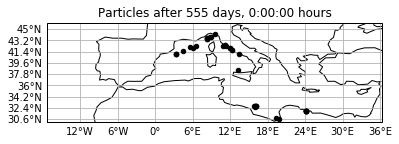

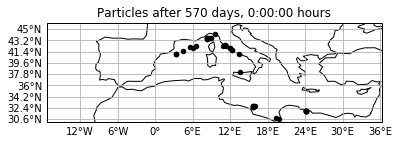

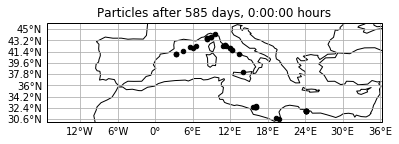

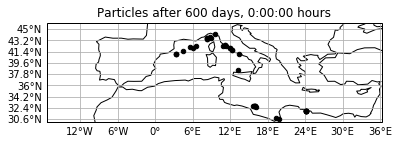

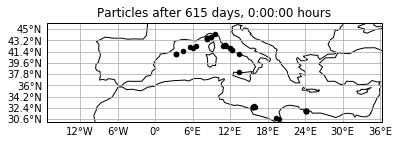

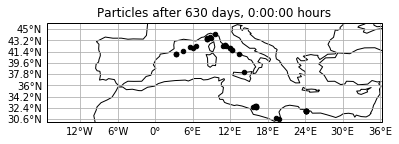

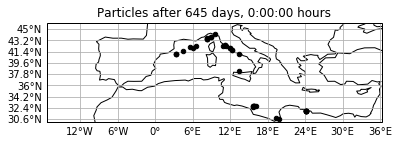

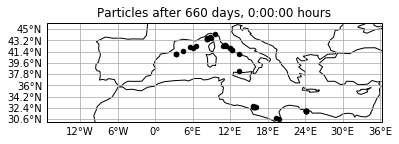

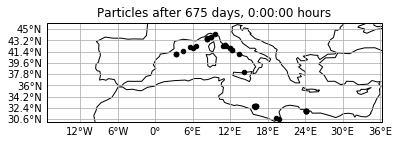

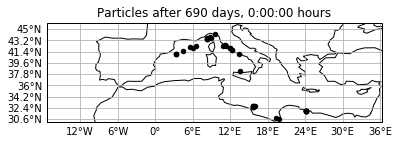

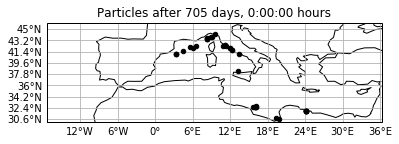

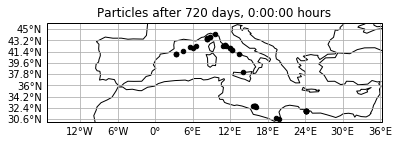

In [69]:
pset.show()

for _ in range(24):
    pset.execute(AdvectionRK4, runtime=timedelta(days=15), dt=timedelta(hours=1))
    pset.show()